In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import os

import cvxpy as cp
import numpy as np


import cvxpy as cp
import numpy as np

np.random.seed(42)


## TODO :
1. Append all the samples and use all of them for gradeints and compare with previous experiment (Done)
2. Add extra term lagarnagian lambda * ( empirical mean ^T X  - r_0) * Empirical mean to the update step with fixed lagarangian multiplier (Done)

In [2]:
def returns(mu, sig):
    #print(mu.shape, sig.shape)
    return np.random.multivariate_normal(mean = mu, cov = sig)

def returns_m(mu, sig, m):
    return np.random.multivariate_normal(mean = mu, cov = sig, size = m)

def ideal(x, beta, mu, sigma):
    return beta*np.dot(sigma, x) - mu

def theta_star(mu, sigma, beta):
    return np.dot(np.linalg.inv(sigma), mu/beta)

def sr(x, mu, sigma, beta, lamda):
    return -np.dot(mu, x) + 0.5*beta*np.dot(x,np.dot(sigma, x)) - np.log(beta)/lamda

def loss_dash(x, beta):
    return -beta*np.exp(beta*x)

def generate_zeta_samples(returns, theta):
    zeta_samples = []
    for r in returns:
        zeta_samples.append([-np.dot(theta, r),-r])
    return zeta_samples

def estimate_h(beta, theta, sr, returns):
    zeta_samples = generate_zeta_samples(returns, theta)
    A_m = 0
    B_m = 0
    for i,x in enumerate(zeta_samples):
        A_m += loss_dash(x[0] - sr, beta)*x[1]
        B_m += loss_dash(x[0] - sr, beta)
    h = A_m/B_m
    return h

def generate_params(size):
    # m zeta samples
    mu = np.random.uniform(0.04, 0.5, size)
    sigma = np.diag(mu+0.05)
    for i in range(size):
        for j in range(i+1, size):
            sigma[i][j] = 0.35*(sigma[i][i])*(sigma[j][j])
            sigma[j][i] = sigma[i][j]
    # print(np.array_str(sigma, precision=2, suppress_small=True))
    # print("mean returns: ", mu)

    return mu, sigma

## Compute optimal solution

In [3]:



n = 10

beta = 1
lamda = 0.2
n = 10
size = n

# Define the problem data
mu, sigma = generate_params(size)

print('Mean = ', mu)
# Define the variables
n = size  # Number of assets
x = cp.Variable(n)
beta = 0.5  # Risk aversion parameter
lmbda = 2.0  # Risk-free rate
mu_mean = np.mean(mu)  # Mean of expected returns

# Define the objective function
objective = -mu @ x + (beta / 2) * cp.quad_form(x, sigma) - cp.log(lmbda) / beta

# Define the constraints
constraints = [sum(x) <= 1, x >= 0, mu.T @ x >= mu_mean]

# Formulate the optimization problem
problem = cp.Problem(cp.Minimize(objective), constraints)

# Solve the problem
problem.solve()

# Display the results
if problem.status == cp.OPTIMAL:
    print("Optimal Portfolio:")
    print("Weights:", x.value)
    print("Expected Return:", mu @ x.value)
    print('R_0 = ', mu_mean)
    print("Portfolio Variance:", x.value.T @ sigma @ x.value)
else:
    print("Optimization problem did not converge.")

Mean =  [0.21228845 0.47732858 0.37671721 0.3153829  0.11176857 0.11175748
 0.06671846 0.43844103 0.31651291 0.36571339]
Optimal Portfolio:
Weights: [-7.74029108e-23  5.05865995e-01  9.33669349e-02 -1.29875116e-22
  3.06251152e-23 -8.03975233e-23 -8.17522238e-23  3.61898649e-01
 -1.15964229e-22  3.88684205e-02]
Expected Return: 0.44952314635517937
R_0 =  0.27926289853823044
Portfolio Variance: 0.2541071025209948


## Constrained Markowitz optimization using fixed lagarange multiplier
Additional term in the gd update step: $ \lambda * \max( 0, (\hat{\mu} ^T X  - r_0)) * \hat{\mu}$ to the update step 

where $\lambda$ is a fixed lagarangian multiplier

In [4]:

MAX_ITER = 1000
m = 10


cc = [1, 10, 1, 0.1, 0.01]
decay = [True]*len(cc)

theta_init = np.random.uniform(0, 1, size)
theta_init = theta_init/np.sum(theta_init)

#true_val = theta_star(mu, sigma, beta)[0]
theta_estimates_exp = []
sr_estimates_exp = []
return_samples = []


# true_val = theta_star(mu, sigma, beta)[0]
true_val = x.value
sr_val_theta_star = sr(true_val, mu, sigma, beta, lamda)

print("True value for theta_1 = ", true_val[0])

# Laganrange multiplier
lag_multiplier = 1
r_0 = np.mean(mu)

for i, c in enumerate(cc):
    #dd = decay[i]
    dd = True
    #conduct 100 experiments

    theta = deepcopy(theta_init)
    theta_estimates = [theta]
    sr_estimates = [sr(theta, mu, sigma, beta, lamda)]

    return_list = []

    for i in range(1, MAX_ITER):
        # Generate samples for zeta
        sr_val = sr(theta, mu, sigma, beta, lamda)
        
        r_samples = returns_m(mu, sigma, m)
        return_list.append(r_samples)

        # IF you want to append all the past samples
        #return_samples = np.vstack(return_list)
        # If not
        return_samples = r_samples
        estimate = estimate_h( beta, theta, sr_val, return_samples)
        r_i = np.mean(return_samples, axis = 0)

        if dd:
            theta = theta - (c/i)*(estimate - 2*lag_multiplier*(np.maximum(0, np.dot(r_i, theta) - r_0)*r_i))
            theta = theta/np.sum(theta)
        else:
            theta = theta - c*(estimate + 2*lag_multiplier*(np.maximum(0, np.dot(r_i, theta) - r_0)*r_i))
            theta = theta/np.sum(theta)
        theta_estimates.append(theta)
        sr_estimates.append(sr(theta, mu, sigma, beta, lamda))
        
    theta_estimates_exp.append(theta_estimates)
    sr_estimates_exp.append(sr_estimates)

True value for theta_1 =  -7.740291076917713e-23


In [5]:
print("Expected Return:", mu @ theta)
print('R_0 = ', mu_mean)

Expected Return: 0.3495283623403775
R_0 =  0.27926289853823044


  adjustable: {'box', 'datalim'}
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  anchor: (float, float) or {'C', 'SW', 'S', 'SE', 'E', 'NE', ...}
  animated: bool
  aspect: {'auto', 'equal'} or float
  autoscale_on: bool
  autoscalex_on: unknown
  autoscaley_on: unknown
  axes_locator: Callable[[Axes, Renderer], Bbox]
  axisbelow: bool or 'line'
  box_aspect: float or None
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  facecolor or fc: color
  figure: `.Figure`
  frame_on: bool
  gid: str
  in_layout: bool
  label: object
  mouseover: bool
  navigate: bool
  navigate_mode: unknown
  path_effects: `.AbstractPathEffect`
  picker: None or bool or float or callable
  position: [left, bottom, width, height] or `~matplotlib.transforms.Bbox`
  prop_cycle: unknown
  rasterization_zorder: float or None
  ras

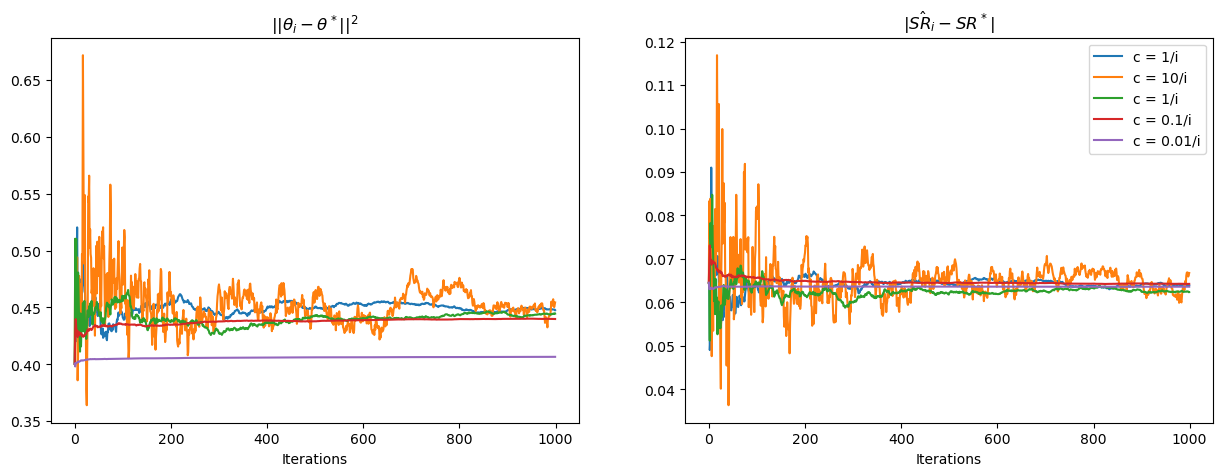

In [6]:

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

custom_ylim = (0, 2.5)

true_val = x.value

# Setting the values for all axes.
plt.setp(axs)

labels = ["c = " + str(cc[i]) + "/i"*decay[i] for i in range(len(cc))]

theta_error = []
sr_error = []
for i in range(len(cc)):

    theta_estimates = theta_estimates_exp[i]
    sr_estimates = sr_estimates_exp[i]

    theta_error.append(np.linalg.norm(theta_estimates - true_val, axis=1))
    sr_error.append(np.abs(sr_estimates - sr_val_theta_star))

    axs[0].plot(range(MAX_ITER), theta_error[-1], label = labels[i])
    axs[0].set_title(r"$||\theta_i - \theta^*||^2$")
    axs[0].set_xlabel("Iterations")

    #axs[1].ylim = (0, 0.1)
    axs[1].plot(range(MAX_ITER), sr_error[-1], label = labels[i])
    axs[1].set_title(r"$|\hat{SR}_i - SR^*|$")
    axs[1].set_xlabel("Iterations")

plt.legend()
plt.show()

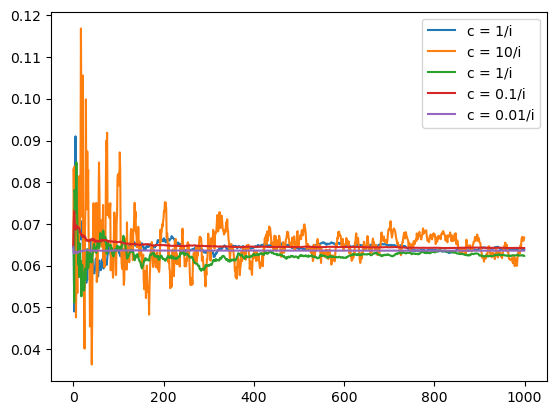

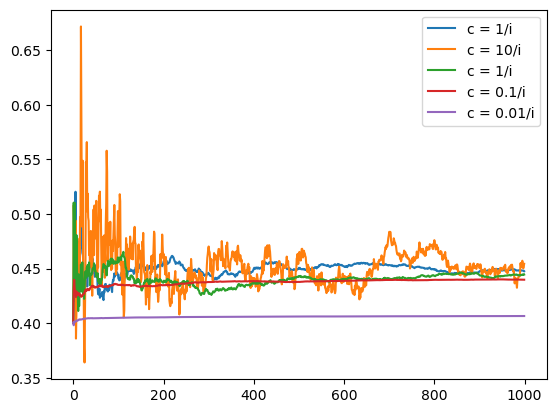

In [7]:
theta_error = np.array(theta_error)
sr_error = np.array(sr_error)

df_theta = pd.DataFrame(theta_error.T, columns = labels)
df_sr = pd.DataFrame(sr_error.T, columns = labels)

df_sr.plot()
plt.show()

df_theta.plot()
plt.show()

In [8]:
# saving all elements as column into a txt file
save = False
if save:
    df_theta.to_csv("theta_error.txt")
    df_sr.to_csv("sr_error.txt")

    np.savetxt("theta_error.txt", theta_error, delimiter=" ")
    np.savetxt("sr_error.txt", sr_error, delimiter=" ")